In [16]:
'''
Imports
'''

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil

from scipy import stats
from scipy.signal import butter, lfilter, freqz

#import tensorflow as tf
import keras

import wfdb
from wfdb import processing

In [17]:
'''
Reading/downloading
'''

with open('RECORDS.txt') as inf:
    s = inf.readline().strip()

print("database/"+s)

#record = wfdb.io.rdrecord("database/"+s)

signals, fields = wfdb.io.rdsamp("database/"+s, channels = [0, 1, 2])
#display(signals)
#display(fields)
#plt.plot(signals)
#plt.show()

#print(fields)

database/patient001/s0010_re


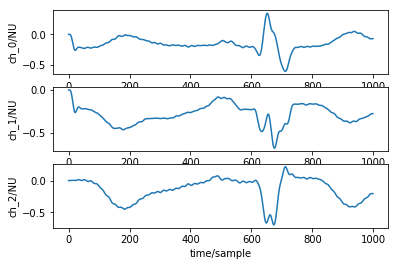

In [54]:
'''
High-frequency filter
'''

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

cutoff=50
fs=fields['fs'] #frequency
order=6

sig_den = np.apply_along_axis(lambda x: butter_lowpass_filter(x, cutoff, fs, order), 0, signals) 

wfdb.plot_items(signal=sig_den[0:1000])

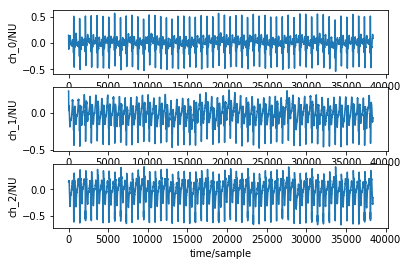

In [57]:
'''
BASELINE CORRECTION
'''

def subtract_baseline(data, radius = 1000):
    baseline = list()
    for i in range(len(data)-radius):
        baseline.append(np.mean(data[i:i+radius]))
    baseline.extend([baseline[-1] for i in range(radius)])
    baseline = np.array(baseline)
    return data - baseline

sig_den_subbase = np.apply_along_axis(subtract_baseline, 0, sig_den)
wfdb.plot_items(signal=sig_den_subbase)

In [61]:
'''
LOCAL R-PEAK FINDING (SEEMS TO BE CORRECT ONLY FOR FIXED radius)
'''
#xqrs = processing.XQRS(sig=signals[:,0], fs=fields['fs'])

#xqrs.detect()

#print(xqrs.qrs_inds)

#peaks = processing.find_peaks(sig = signals[:,0])

# Hard peaks
#print(peaks[0])

# Soft peaks
#print(peaks[1])

#print(peaks)

local_peaks = wfdb.processing.find_local_peaks(sig=sig_den_subbase[:,0], radius=500)
local_peaks_1 = wfdb.processing.find_local_peaks(sig=sig_den_subbase[:,1], radius=500)
local_peaks_2 = wfdb.processing.find_local_peaks(sig=sig_den_subbase[:,2], radius=500)


print(local_peaks, local_peaks_1, local_peaks_2)
#print(signals[local_peaks,0], signals[local_peaks,1], signals[local_peaks,2], sep = '\n')

[    1   652  1397  2124  2851  3596  4337  5067  5810  6553  7275  8001
  8737  9460 10171 10895 11622 12343 13059 13793 14533 15262 15988 16729
 17466 18190 18922 19661 20391 21108 21843 22579 23305 24029 24767 25499
 26224 26964 27707 28440 29173 29919 30664 31397 32135 32885 33626 34358
 35107 35863 36597 37327 38074] [    2  1269  1986  2712  3430  4198  4941  5670  6409  7142  7863  8593
  9322 10037 10756 11484 12203 12932 13658 14393 15119 15851 16598 17316
 18052 18789 19506 20235 20971 21688 22434 23154 23893 24629 25365 26088
 26823 27565 28307 29031 29789 30529 31251 32006 32750 33487 34216 34974
 35719 36452 37195 37936] [  712  1455  2186  2911  3655  4398  5128  5869  6612  7335  8061  8798
  9521 10232 10956 11681 12402 13119 13854 14594 15321 16050 16790 17528
 18252 18982 19719 20451 21169 21903 22638 23367 24089 24828 25560 26285
 27025 27768 28502 29232 29980 30726 31456 32194 32946 33688 34417 35167
 35923 36656 37389 38133]


In [92]:
'''
ERIC'S PERIOD FINDING

cardiac cycle = 1 sec
freq = frequency (Hz)  - for debug it'll be 1000.

so we can use the lenght of cardiac cycle (1 sec * freq) = 1000 as initial estimation for normal person

'''


freq = 1000
lc = np.argmax(sig_den_subbase[freq:freq*2,0]) - np.argmax(sig_den_subbase[0:freq,0]) + freq

print(lc)

745


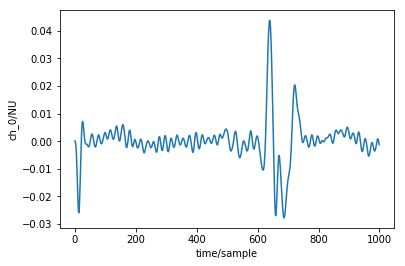

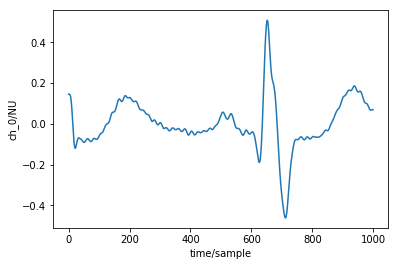

[  652  1397  2124  2851  3596  4337  5067  5810  6553  7275  8001  8737
  9460 10171 10895 11622 12343 13059 13793 14533 15262 15988 16729 17466
 18190 18922 19661 20391 21108 21843 22579 23305 24029 24767 25499 26224
 26964 27707 28440 29173 29919 30664 31397 32135 32885 33626 34358 35107
 35863 36597 37327 38074]


In [96]:
'''
FINDING R-PEAK USING DERIVATIVE
'''

# Illustration of derivative
k = np.apply_along_axis(np.diff, 0, sig_den_subbase)
wfdb.plot_items(signal=k[0:1000,0])
wfdb.plot_items(signal=sig_den_subbase[0:1000,0])

def rpeak_der(data, radius=500, small_window=50):
    der = np.diff(data)
    local_der_maxs = wfdb.processing.find_local_peaks(sig=data, radius=radius)
    local_der_maxs = local_der_maxs[local_der_maxs > small_window]
    local_maxs = np.array(list(map(lambda x: np.argmax(data[x-small_window:x+small_window])+x-small_window, 
                     local_der_maxs)))
    return local_maxs

rpeaks = rpeak_der(sig_den_subbase[:,0], radius = lc//2)
print(rpeaks)



Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[]
[  612  1357  2084  2811  3556  4297  5028  5769  6513  7235  7961  8697
  9421 10132 10855 11582 12303 13020 13754 14494 15222 15949 16690 17428
 18151 18882 19621 20351 21068 21802 22539 23265 23988 24727 25460 26184
 26923 27667 28401 29132 29879 30625 31356 32095 32845 33587 34318 35067
 35823 36557 37287 38067]


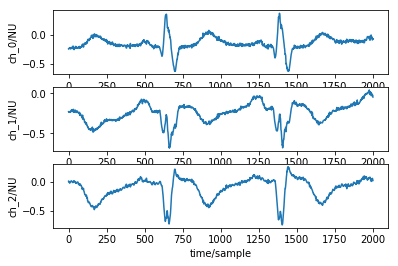

[-0.3585 -0.3895 -0.2895 -0.308  -0.3485 -0.359  -0.314  -0.311  -0.35
 -0.281  -0.239  -0.2945 -0.265  -0.259  -0.228  -0.2745 -0.2395 -0.2195
 -0.1615 -0.158  -0.1515 -0.1015 -0.0665 -0.0995 -0.0715 -0.071  -0.172
 -0.1765 -0.14   -0.171  -0.212  -0.17   -0.1645 -0.2225 -0.2805 -0.203
 -0.1555 -0.113  -0.155  -0.16   -0.173  -0.2135 -0.1835 -0.2235 -0.221
 -0.244  -0.1075 -0.1325 -0.086  -0.1295 -0.1165  0.526 ]


In [88]:
#xqrs_ind = processing.xqrs_detect(sig=signals[:,0], fs=fields['fs'], sampto = 10000)

#print(xqrs_ind)

'''
FINGING R-PEAKS (WRONG)
'''

qrs_ind_1 = processing.gqrs_detect(sig=signals[:,0], fs=fields['fs'])

print(qrs_ind)

'''
for i in peaks[0]:
    if i not in qrs_ind:
        print(i, end = " ")
'''
        
        
wfdb.plot_items(signal=signals[0:2000,:])

# Peak height
#qrs_h = signals[qrs_ind,0]

print(qrs_h)

[         nan          nan          nan ...,  82.19178009  82.19178009
  82.19178009]
[ 0.3008641   0.30243519  0.30322074 ...,  0.61233307  0.59976434
  0.59897879]


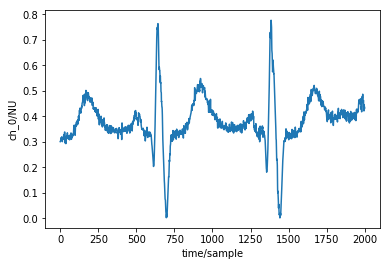

In [68]:
'''
COMPUTING HEART RATE
'''

hr = wfdb.processing.compute_hr(sig_len=len(signals[:,0]), 
                                qrs_inds=qrs_ind, 
                                fs=fields['fs'])

print(hr)

norm_sig = wfdb.processing.normalize_bound(sig=signals[:,0], lb=0, ub=1)

print(norm_sig)

wfdb.plot_items(signal=norm_sig[0:2000], ann_samp=[xqrs.qrs_inds])

In [ ]:
'''
Препроцессинг
1) фильтр низких частот - сглаживание сигнала (sklearn???)
* частота среза подбирается экспериментально
2) высота пиков по амплитуде и расстояние между ними, углы наклона между ними
3) ищем R-пики, откладываем окна влево-вправо - это кардиоциклы; внутри окон ищем p, q, s, t точки.
'''



{'record_name': 'rec_1', 'n_sig': 2, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 10000, 'base_time': None, 'base_date': None, 'comments': ['Age: 25', 'Sex: male', 'ECG date: 07.12.2004'], 'sig_name': ['ECG I', 'ECG I filtered'], 'p_signal': array([[-0.085, -0.115],
       [-0.08 , -0.115],
       [-0.07 , -0.12 ],
       ..., 
       [-0.065, -0.035],
       [-0.08 , -0.035],
       [-0.08 , -0.035]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['rec_1.dat', 'rec_1.dat'], 'fmt': ['16', '16'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [12, 12], 'adc_zero': [0, 0], 'init_value': [-17, -23], 'checksum': [17532, 2004], 'block_size': [0, 0]}


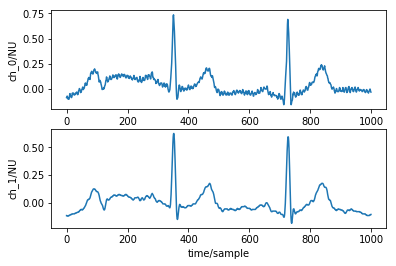

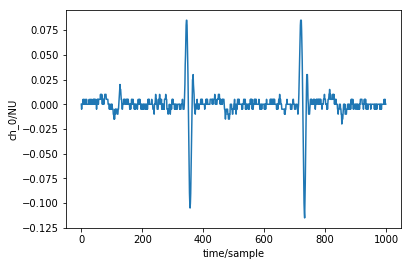

In [78]:
'''
ПРОБУЕМ БАЗУ ECGID
'''

with open('ecg/ecgid/RECORDS') as inf:
    s = inf.readline().strip()
    
record = wfdb.io.rdrecord('ecg/ecgid/'+s)

print(record.__dict__)

sig, fd = wfdb.io.rdsamp('ecg/ecgid/'+s)

wfdb.plot_items(signal=sig[:1000,:])

der = np.diff(sig[:,1])

wfdb.plot_items(signal=der[:1000])